## Проектная работа по предсказанию качества жизни в странах по ряду признаков

Загрузка необходимых библиотек:

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np       
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

## Датасет, с которым буду работать:

In [2]:
os.chdir('C:\\Users\\Nvero\\OneDrive\\MSM')
df = pd.read_csv('itog.csv', sep = ',')
print(df.shape)
df.head()

(679, 11)


COUNTRY  Unnamed: 0 Q_OF_LIFE POLLUTION PRICE_TO_INCOME_RATIO  \
0           Switzerland           0     194.1      35.5                   6.5   
1               Germany           1     184.4      45.1                   4.8   
2                Norway           2     183.4      19.2                   7.1   
3  United Arab Emirates           3     177.1      69.2                   4.5   
4           New Zealand           4     174.3      17.1                   5.7   

   YEAR CRIME           GDP    GDP_PER_CAP           TAX  \
0  2012  25.8  6.921097e+11   86547.670891   progressive   
1  2012  21.2  3.527345e+12   43858.363055   progressive   
2  2012  19.1  5.095063e+11  101524.141852   progressive   
3  2012  35.9  3.745906e+11   40976.490746  proportional   
4  2012  46.8  1.762067e+11   39973.380759   progressive   

             Regional indicator  
0                Western Europe  
1                Western Europe  
2                Western Europe  
3  Middle East and North Africa  
4         North America and ANZ

# Часть 2. Предварительная обработка

Описание переменных:

1)COUNTRY - название страны, по которой собраны данные
2)YEAR - год, в который были зафиксированы данные
3)Q_OF_LIFE - показатель качества жизни
4)POLLUTION - индекс загрязненности окружающей среды
5)PRICE_TO_INCOME_RATIO - индекс соотношения цен и доходов населения
6)CRIME - индекс уровня преступности в стране
7)GDP - ВВП государства
8)GDP_PER_CAP - ВВП на душу населения
9)TAX - система налогооблажения в стране(прогрессивная/пропорциональная)
10)Regional indicator - региональная принадлежность

Избавляемся от бесполезного столбца с номерами наблюдений:

In [3]:
df.drop('Unnamed: 0', axis=1,inplace=True)
df.head()

COUNTRY Q_OF_LIFE POLLUTION PRICE_TO_INCOME_RATIO  YEAR CRIME  \
0           Switzerland     194.1      35.5                   6.5  2012  25.8   
1               Germany     184.4      45.1                   4.8  2012  21.2   
2                Norway     183.4      19.2                   7.1  2012  19.1   
3  United Arab Emirates     177.1      69.2                   4.5  2012  35.9   
4           New Zealand     174.3      17.1                   5.7  2012  46.8   

            GDP    GDP_PER_CAP           TAX            Regional indicator  
0  6.921097e+11   86547.670891   progressive                Western Europe  
1  3.527345e+12   43858.363055   progressive                Western Europe  
2  5.095063e+11  101524.141852   progressive                Western Europe  
3  3.745906e+11   40976.490746  proportional  Middle East and North Africa  
4  1.762067e+11   39973.380759   progressive         North America and ANZ

Обработка пропусков:

In [4]:
df.isnull().sum()

COUNTRY                  0
Q_OF_LIFE                0
POLLUTION                0
PRICE_TO_INCOME_RATIO    7
YEAR                     0
CRIME                    2
GDP                      7
GDP_PER_CAP              7
TAX                      0
Regional indicator       0
dtype: int64

In [5]:
df.dtypes

COUNTRY                   object
Q_OF_LIFE                 object
POLLUTION                 object
PRICE_TO_INCOME_RATIO     object
YEAR                       int64
CRIME                     object
GDP                      float64
GDP_PER_CAP              float64
TAX                       object
Regional indicator        object
dtype: object

4 столбца считываются как категориальные переменные, сделаю их числовыми:

In [6]:
df['CRIME'].fillna('0,0', inplace=True)
df['PRICE_TO_INCOME_RATIO'].fillna('0,0', inplace=True)

In [7]:
df['Q_OF_LIFE'] = df['Q_OF_LIFE'].apply(lambda x: float(x.replace(',','.').replace('"','')))
df['POLLUTION'] = df['POLLUTION'].apply(lambda x: float(x.replace(',','.').replace('"','')))
df['CRIME'] = df['CRIME'].apply(lambda x: float(x.replace(',','.').replace('"','')))
df['PRICE_TO_INCOME_RATIO'] = df['PRICE_TO_INCOME_RATIO'].apply(lambda x: float(x.replace(',','.').replace('"','')))


In [8]:
df = df.drop('YEAR', axis = 1) #эта колонка имела значение только при парсинге и конкатировании таблиц, в дальнейшем не пригодится

In [9]:
df.dtypes

COUNTRY                   object
Q_OF_LIFE                float64
POLLUTION                float64
PRICE_TO_INCOME_RATIO    float64
CRIME                    float64
GDP                      float64
GDP_PER_CAP              float64
TAX                       object
Regional indicator        object
dtype: object

In [10]:
df.isnull().sum()

COUNTRY                  0
Q_OF_LIFE                0
POLLUTION                0
PRICE_TO_INCOME_RATIO    0
CRIME                    0
GDP                      7
GDP_PER_CAP              7
TAX                      0
Regional indicator       0
dtype: int64

!Для того, чтобы CRIME и PRICE_TO_INCOME_RATIO стали числовыми для работы функции пришлось заменить пропуски на нули! Но это ненадолго

Разделим датасет на трейн и тест и только после этого избавимся от пропусков. Это предотвратит "подглядывание" в тестовые данные в будущем при построении модели линейной регрессии:

Т.к. в датафрейме собраны совершенно разнообразные страны, там могут находиться как очень бедные государства с малым ВВП и ВВП на душу населения и высокими показателями преступности, так и богатые. Это говорит о том, что велика вероятность наличия выбросов. Лучше заполнить пропуски медианными значениями, которые не зависят от выбросов.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Q_OF_LIFE']), df['Q_OF_LIFE'], test_size=0.2, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

#избавляемся от искусственно добавленных нулей:
X_train['CRIME'] = X_train['CRIME'].where(X_train['CRIME']!=0, X_train['CRIME'].median())
X_test['CRIME'] = X_test['CRIME'].where(X_test['CRIME']!=0, X_train['CRIME'].median())
X_train['PRICE_TO_INCOME_RATIO'] = X_train['PRICE_TO_INCOME_RATIO'].where(X_train['PRICE_TO_INCOME_RATIO']!=0, X_train['PRICE_TO_INCOME_RATIO'].median())
X_test['PRICE_TO_INCOME_RATIO'] = X_test['PRICE_TO_INCOME_RATIO'].where(X_test['PRICE_TO_INCOME_RATIO']!=0, X_train['PRICE_TO_INCOME_RATIO'].median())

#использован универсальный вариант кода
imputer = SimpleImputer(strategy='median')
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

X_train[numeric_cols] = imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])

X_train_cat = X_train[categorical_cols]
X_test_cat = X_test[categorical_cols]

missing_cols = set(X_train_cat.columns) - set(X_test_cat.columns)
for c in missing_cols:
    X_test_cat[c] = 0
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)


X_train_processed = pd.concat([X_train[numeric_cols], X_train_cat], axis=1)
X_test_processed = pd.concat([X_test[numeric_cols], X_test_cat], axis=1)
X_train_processed.isnull().sum()

POLLUTION                0
PRICE_TO_INCOME_RATIO    0
CRIME                    0
GDP                      0
GDP_PER_CAP              0
COUNTRY                  0
TAX                      0
Regional indicator       0
dtype: int64

In [12]:
X_test_processed.isnull().sum()

POLLUTION                0
PRICE_TO_INCOME_RATIO    0
CRIME                    0
GDP                      0
GDP_PER_CAP              0
COUNTRY                  0
TAX                      0
Regional indicator       0
dtype: int64

Пропусков больше не осталось, переходим к следующему этапу

# Часть 3. Визуализация

Для выполнения всех графиков будет использован X_train_processed и y_train. Первым делом посмотрим на гистограммы распределений числовых признаков:

In [13]:
plt.figure(figsize = (10,5))

y_train.hist(bins=50, color='red', alpha=0.5)
plt.xlabel('Значение целевой переменной Q_OF_LIFE')
plt.ylabel('Частота')
plt.title('Гистограмма Q_OF_LIFE');

Не напоминает никакое распределение

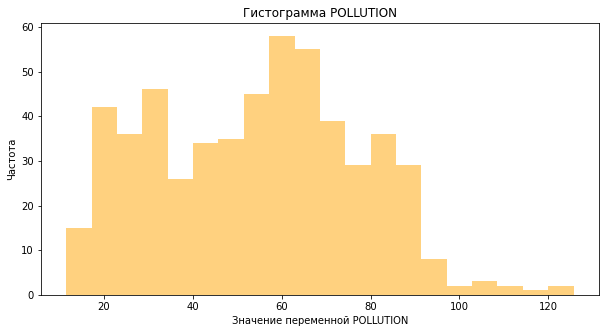

In [14]:
plt.figure(figsize = (10,5))

plt.hist(X_train_processed['POLLUTION'], bins=20, color='orange', alpha=0.5)
plt.xlabel('Значение переменной POLLUTION')
plt.ylabel('Частота')
plt.title('Гистограмма POLLUTION');

Гистограмма смутно напоминает нормальное распределение с выбросами в левом хвосте

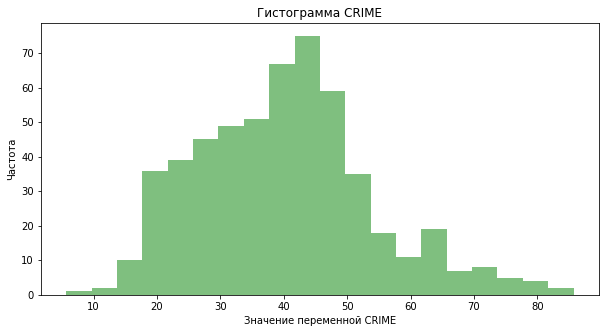

In [15]:
plt.figure(figsize = (10,5))

plt.hist(X_train_processed['CRIME'], bins=20, color='green', alpha=0.5)
plt.xlabel('Значение переменной CRIME')
plt.ylabel('Частота')
plt.title('Гистограмма CRIME');

Гистограмма смутно напоминает нормальное распределение с выбросами в левом хвосте

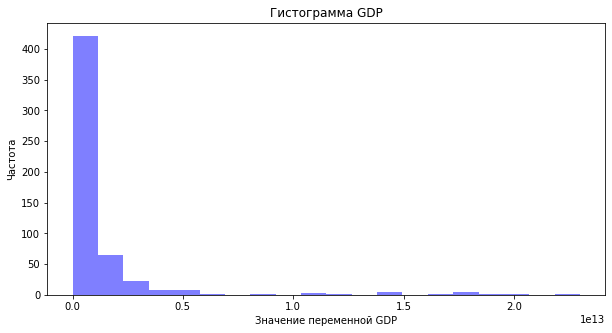

In [16]:
plt.figure(figsize = (10,5))

plt.hist(X_train_processed['GDP'], bins=20, color='blue', alpha=0.5)
plt.xlabel('Значение переменной GDP')
plt.ylabel('Частота')
plt.title('Гистограмма GDP');

Похоже на экспоненциальное распределение

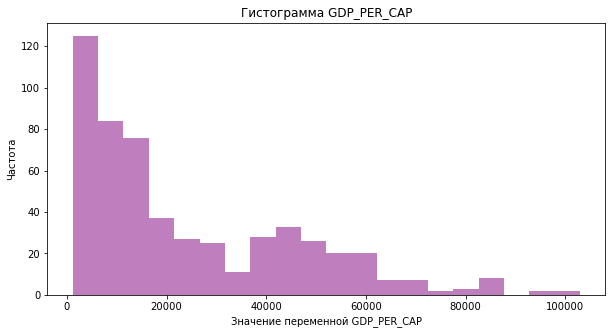

In [17]:
plt.figure(figsize = (10,5))

plt.hist(X_train_processed['GDP_PER_CAP'], bins=20, color='purple', alpha=0.5)
plt.xlabel('Значение переменной GDP_PER_CAP')
plt.ylabel('Частота')
plt.title('Гистограмма GDP_PER_CAP');

Также напоминает экспоненциальное распределение, но уже намного меньше

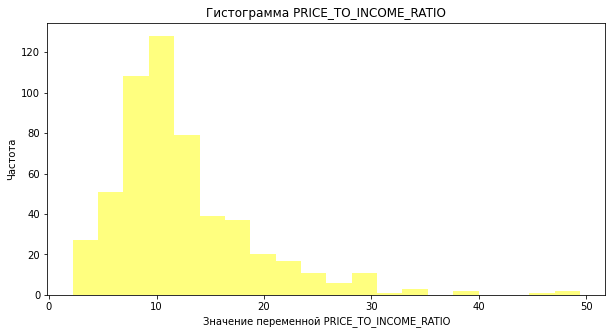

In [18]:
plt.figure(figsize = (10,5))

plt.hist(X_train_processed['PRICE_TO_INCOME_RATIO'], bins=20, color='yellow', alpha=0.5)
plt.xlabel('Значение переменной PRICE_TO_INCOME_RATIO')
plt.ylabel('Частота')
plt.title('Гистограмма PRICE_TO_INCOME_RATIO');

Если убрать выбросы в правом конце хвоста распределения, напоминает нормальное распределение

Теперь построим диаграммы рассеивания, что определить, есть ли корреляция между целевой переменной и предикторами:

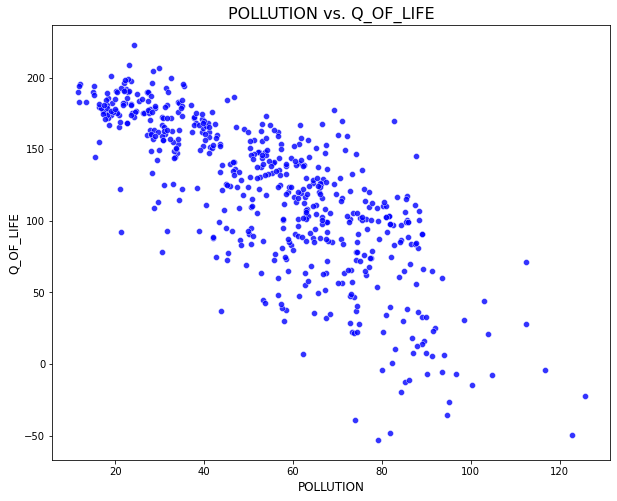

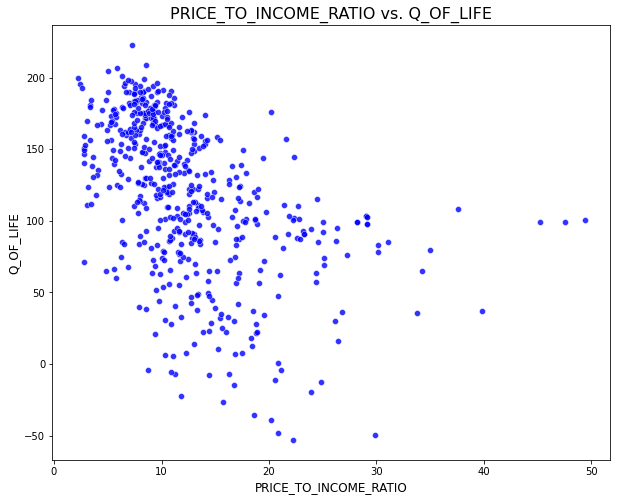

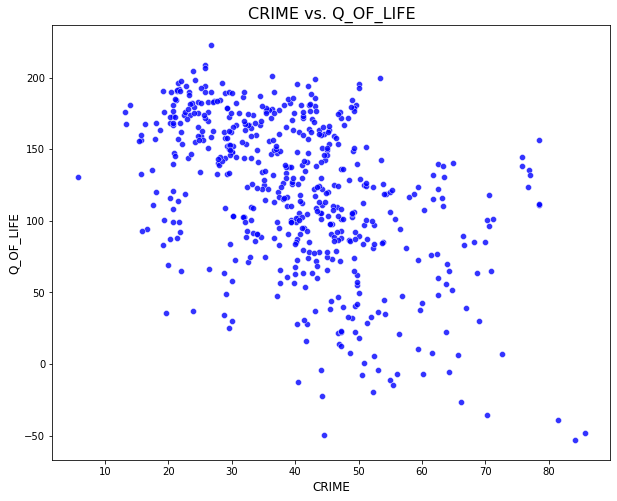

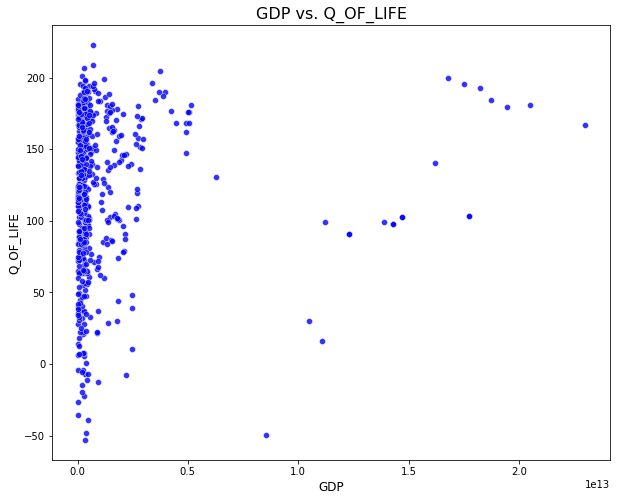

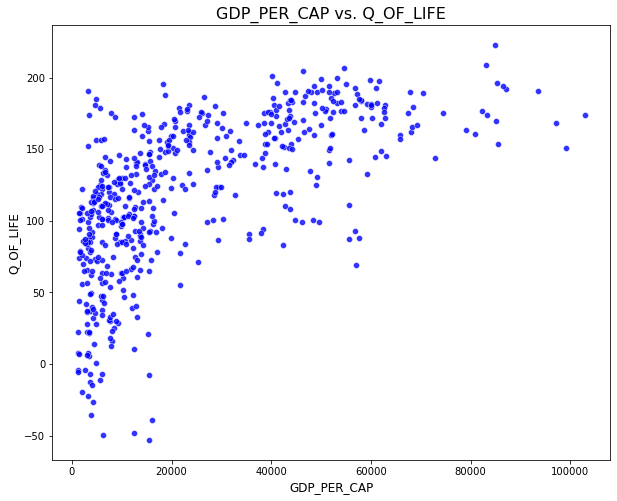

In [19]:
for col in numeric_cols:
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=X_train_processed, x=col, y=y_train, alpha=0.8, color='blue')
    plt.xlabel(col, fontsize=12)
    plt.title(f"{col} vs. Q_OF_LIFE", fontsize=16)
    plt.ylabel("Q_OF_LIFE", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

Между POLUTTION,CRIME и Q_OF_LIFE явно присутствует прямая обратная взаимосвязь. PRICE_TO_INCOME и GDP_PER_CAP с целевой переменной будто бы распределены относительно друг друга логарифмически. А GDP и Q_OF_LIFE соотносятся очень странно. Попробуем преобразовать три эти диаграммы:

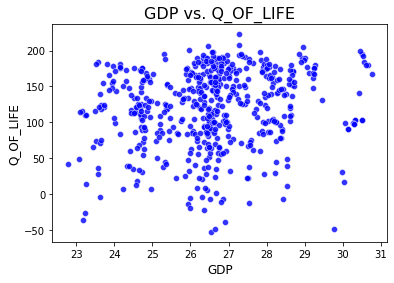

In [20]:
col = 'GDP'
sns.scatterplot(data=X_train_processed, x=np.log(X_train_processed[col]), y=y_train, alpha=0.8, color='blue')
plt.xlabel(col, fontsize=12)
plt.title(f"{col} vs. Q_OF_LIFE", fontsize=16)
plt.ylabel("Q_OF_LIFE", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Судя по этому графику между GDP и Q_OF_LIFE нет ни положительной, ни отрицательной взаимосвязи. 

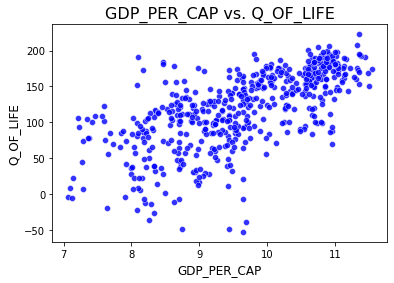

In [21]:
col = 'GDP_PER_CAP'
sns.scatterplot(data=X_train_processed, x=np.log(X_train_processed[col]), y=y_train, alpha=0.8, color='blue')
plt.xlabel(col, fontsize=12)
plt.title(f"{col} vs. Q_OF_LIFE", fontsize=16)
plt.ylabel("Q_OF_LIFE", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Тут явно прослеживается прямая взаимосвязь. Логарифмизация переменной пошла на пользу

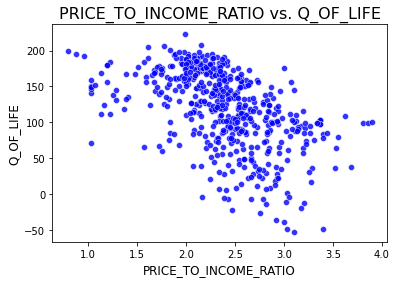

In [22]:
col = 'PRICE_TO_INCOME_RATIO'
sns.scatterplot(data=X_train_processed, x=np.log(X_train_processed[col]), y=y_train, alpha=0.8, color='blue')
plt.xlabel(col, fontsize=12)
plt.title(f"{col} vs. Q_OF_LIFE", fontsize=16)
plt.ylabel("Q_OF_LIFE", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Этот график также стал выглядеть лучше, видна обратная взаимосвязь.

# Часть 4. Новые признаки

На основании прошлого пункта-визуализации можно попробовать добавить к обучающей и тестовой выборке новые столбцы: логарифм от GDP_PER_CAP и PRICE_TO_INCOME_RATIO, это должно сделать будущую модель более точной.

In [23]:
X_train_processed['log_CAP'] = np.log(X_train_processed['GDP_PER_CAP'])
X_test_processed['log_CAP'] = np.log(X_test_processed['GDP_PER_CAP'])
X_train_processed['log_RATIO'] = np.log(X_train_processed['PRICE_TO_INCOME_RATIO'])
X_test_processed['log_RATIO'] = np.log(X_test_processed['PRICE_TO_INCOME_RATIO'])
X_train_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO  CRIME           GDP   GDP_PER_CAP  \
430       30.5                   10.0   34.5  2.423130e+11  23563.000000   
249       53.2                   14.7   54.0  9.929038e+10   6124.490887   
220       65.2                    3.1   78.4  3.467098e+11   6259.839681   
18        51.9                    7.8   40.6  2.162366e+11  20564.889862   
244       65.7                   14.3   50.0  8.060408e+10   3843.780672   

          COUNTRY           TAX           Regional indicator    log_CAP  \
430      Portugal  proportional               Western Europe  10.067433   
249       Ecuador   progressive  Latin America and Caribbean   8.720051   
220  South Africa   progressive           Sub-Saharan Africa   8.741910   
18       Portugal   progressive               Western Europe   9.931341   
244     Sri Lanka   progressive                   South Asia   8.254212   

     log_RATIO  
430   2.302585  
249   2.687847  
220   1.131402  
18    2.054124  
244   2.660260

Нам известны названия стран, по которым мы собирали информацию. Страны подразделяются на развитые и развивающиеся. Добавим в датафреймы столбец, который будет показывать к какому типу страны относится наблюдение:

In [24]:
developed = ['Australia', 'Austria', 'Belgium', 'Canada', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'New Zealand', 'Norway', 'Poland', 'Portugal', 'Singapore', 'Slovakia', 'Slovenia','UAE','Slovak Republic', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'United Arab Emirates', 'United Kingdom', 'United States']

In [25]:
X_train_processed['Type'] = X_train_processed['COUNTRY'].apply(lambda x: 'developed' if x in developed else 'developing')
X_test_processed['Type'] = X_test_processed['COUNTRY'].apply(lambda x: 'developed' if x in developed else 'developing')
X_train_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO  CRIME           GDP   GDP_PER_CAP  \
430       30.5                   10.0   34.5  2.423130e+11  23563.000000   
249       53.2                   14.7   54.0  9.929038e+10   6124.490887   
220       65.2                    3.1   78.4  3.467098e+11   6259.839681   
18        51.9                    7.8   40.6  2.162366e+11  20564.889862   
244       65.7                   14.3   50.0  8.060408e+10   3843.780672   

          COUNTRY           TAX           Regional indicator    log_CAP  \
430      Portugal  proportional               Western Europe  10.067433   
249       Ecuador   progressive  Latin America and Caribbean   8.720051   
220  South Africa   progressive           Sub-Saharan Africa   8.741910   
18       Portugal   progressive               Western Europe   9.931341   
244     Sri Lanka   progressive                   South Asia   8.254212   

     log_RATIO        Type  
430   2.302585   developed  
249   2.687847  developing  
220   1.131402  developing  
18    2.054124   developed  
244   2.660260  developing

Также добавим признак Regime, который будет характеризовать политический режим в стране:

In [26]:
not_demokrat =['China', 'North Korea', 'Cuba', 'Vietnam', 'Laos', 'Iran', 'Saudi Arabia', 'Syria', 'Belarus', 'Russia', 'Kazakhstan', 'Uzbekistan', 'Turkmenistan', 'Tajikistan', 'Eritrea', 'Sudan', 'Zimbabwe', 'Venezuela', 'Ethiopia', 'Nicaragua', 'Chad', 'Bahrain', 'Oman', 'United Arab Emirates', 'UAE', 'Qatar', 'Egypt']

In [27]:
X_train_processed['Regime'] = X_train_processed['COUNTRY'].apply(lambda x: 'no democracy' if x in not_demokrat else 'democracy')
X_test_processed['Regime'] = X_test_processed['COUNTRY'].apply(lambda x: 'no democracy' if x in not_demokrat else 'democracy')
X_train_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO  CRIME           GDP   GDP_PER_CAP  \
430       30.5                   10.0   34.5  2.423130e+11  23563.000000   
249       53.2                   14.7   54.0  9.929038e+10   6124.490887   
220       65.2                    3.1   78.4  3.467098e+11   6259.839681   
18        51.9                    7.8   40.6  2.162366e+11  20564.889862   
244       65.7                   14.3   50.0  8.060408e+10   3843.780672   

          COUNTRY           TAX           Regional indicator    log_CAP  \
430      Portugal  proportional               Western Europe  10.067433   
249       Ecuador   progressive  Latin America and Caribbean   8.720051   
220  South Africa   progressive           Sub-Saharan Africa   8.741910   
18       Portugal   progressive               Western Europe   9.931341   
244     Sri Lanka   progressive                   South Asia   8.254212   

     log_RATIO        Type     Regime  
430   2.302585   developed  democracy  
249   2.687847  developing  democracy  
220   1.131402  developing  democracy  
18    2.054124   developed  democracy  
244   2.660260  developing  democracy

Названия стран были необходимы только для блоков Новые признаки. В дальнейшем они будут бесполезны, поэтому просто уберу их:

In [28]:
X_train_processed.drop(['COUNTRY'], axis = 1, inplace = True)
X_test_processed.drop(['COUNTRY'], axis = 1, inplace = True)
X_train_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO  CRIME           GDP   GDP_PER_CAP  \
430       30.5                   10.0   34.5  2.423130e+11  23563.000000   
249       53.2                   14.7   54.0  9.929038e+10   6124.490887   
220       65.2                    3.1   78.4  3.467098e+11   6259.839681   
18        51.9                    7.8   40.6  2.162366e+11  20564.889862   
244       65.7                   14.3   50.0  8.060408e+10   3843.780672   

              TAX           Regional indicator    log_CAP  log_RATIO  \
430  proportional               Western Europe  10.067433   2.302585   
249   progressive  Latin America and Caribbean   8.720051   2.687847   
220   progressive           Sub-Saharan Africa   8.741910   1.131402   
18    progressive               Western Europe   9.931341   2.054124   
244   progressive                   South Asia   8.254212   2.660260   

           Type     Regime  
430   developed  democracy  
249  developing  democracy  
220  developing  democracy  
18    developed  democracy  
244  developing  democracy

# Гипотезы

Проверим гипотезы о:
 1)Влиянии признаков на таргет(альфа = 0.05)
 2)Гипотеза о нормальности распределения ответов

### 1.1)  t-тест для определения статистически значимых различий между средними значениями целевой переменной для каждой группы - демократических и недемократических государств.

In [30]:
regime_democracy = y_train[X_train_processed['Regime'] == 'democracy']
regime_no_democracy = y_train[X_train_processed['Regime'] == 'no democracy']

t_statistic, p_value = stats.ttest_ind(regime_democracy, regime_no_democracy)

print("T-тест:")
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

T-тест:
T-статистика: 5.565163988803305
P-значение: 4.12603535862296e-08


P-value < 0.05 (установленного уровня значимости), т.е. нулевая гипотеза о том, что средние значения в двух группах одинаковы, отверается в пользу альтернативной гипотезы о наличии статистически значимого различия между группами. Т.е. значение признака Regime оказывает влияние на значение целевой перменной(на качество жизни в стране)

### 1.2)  t-тест для определения статистически значимых различий между средними значениями целевой переменной для каждой группы - развитых и развивающихся стран.

In [31]:
type_developed = y_train[X_train_processed['Type'] == 'developed']
type_developing = y_train[X_train_processed['Type'] == 'developing']

t_statistic, p_value = stats.ttest_ind(type_developed, type_developing)

print("T-тест:")
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

T-тест:
T-статистика: 20.504291199871066
P-значение: 1.4616899573403204e-69


P-value < 0.05 (установленного уровня значимости), т.е. нулевая гипотеза о том, что средние значения в двух группах одинаковы, отверается в пользу альтернативной гипотезы о наличии статистически значимого различия между группами. Т.е. значение признака Type оказывает влияние на значение целевой перменной(на качество жизни в стране)

### 1.3)  t-тест для определения статистически значимых различий между средними значениями целевой переменной для каждой группы - стран с пропорциональной и прогрессивной ставкой налогооблажения

In [32]:
regime_democracy = y_train[X_train_processed['TAX'] == 'proportional']
regime_no_democracy = y_train[X_train_processed['TAX'] == 'progressive']

t_statistic, p_value = stats.ttest_ind(regime_democracy, regime_no_democracy)

print("T-тест:")
print(f"T-статистика: {t_statistic}")
print(f"P-значение: {p_value}")

T-тест:
T-статистика: 0.5539713171717346
P-значение: 0.5798273711870618


### 2.1)  Тест на нормальность ответов(целевой переменной). Критерий Шапиро-Уилка

In [33]:
from scipy.stats import shapiro

statistic, p_value = shapiro(y_train)

print("Статистика теста:", statistic)
print("p-value:", p_value)

alpha = 0.05 
if p_value > alpha:
    print("Распределение ответов в y_train является нормальным.")
else:
    print("Распределение ответов в y_train не является нормальным.")

Статистика теста: 0.9548541307449341
p-value: 7.748753028113953e-12
Распределение ответов в y_train не является нормальным.


### 2.2)  Тест на нормальность ответов(целевой переменной). Критерия Харке-Бера

In [34]:
from scipy.stats import jarque_bera

jb_stat, jb_p_value = jarque_bera(y_train)

if jb_p_value > 0.05:
    print("Распределение ответов в y_train является нормальным.")
else:
    print("Распределение ответов в y_train не является нормальным.")

Распределение ответов в y_train не является нормальным.


### 2.3)  Тест на нормальность ответов(целевой переменной). Критерия  Андерсона-Дарлинга

In [170]:
from scipy.stats import anderson

ad_stat, ad_critical_values, ad_significance_levels = anderson(y_train, dist='norm')

if ad_stat < ad_critical_values[2]:
    print("Распределение ответов в y_train является нормальным.")
else:
    print("Распределение ответов в y_train не является нормальным.")

Распределение ответов в y_train не является нормальным.


Все статистические тесты показали, что целевая переменная не подчиняется нормальномк закону распределения. Это не здорово, но живем дальше

(array([ 1.,  2.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
         1.,  1.,  1.,  3.,  3.,  0.,  1.,  0.,  4.,  1.,  2.,  1.,  2.,
         1.,  5.,  1.,  3.,  4.,  4.,  5.,  4.,  2.,  2.,  4.,  3.,  1.,
         5.,  1.,  5.,  9.,  4.,  3.,  7.,  5.,  6.,  3.,  8., 14.,  8.,
        13.,  5.,  6., 19., 11.,  9.,  9., 10.,  7.,  9., 10., 11., 14.,
         4.,  8., 10.,  6., 11.,  9.,  9., 11., 12., 10.,  7., 13., 11.,
        12., 12., 12., 11., 16., 16., 12., 12.,  7.,  5., 12.,  5.,  4.,
         3.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([-53.   , -50.241, -47.482, -44.723, -41.964, -39.205, -36.446,
        -33.687, -30.928, -28.169, -25.41 , -22.651, -19.892, -17.133,
        -14.374, -11.615,  -8.856,  -6.097,  -3.338,  -0.579,   2.18 ,
          4.939,   7.698,  10.457,  13.216,  15.975,  18.734,  21.493,
         24.252,  27.011,  29.77 ,  32.529,  35.288,  38.047,  40.806,
         43.565,  46.324,  49.083,  51.842,  54.601,  57.36 ,  60.119,
        

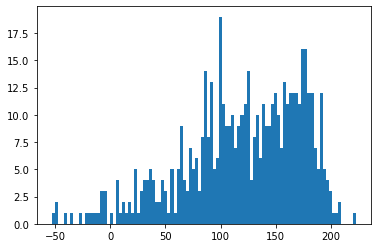

In [35]:
plt.hist((y_train), bins = 100)

# Машинка

### Сначала посмотрим на catboost

In [36]:
cat = [i for i in X_train_processed if X_train_processed[i].dtype == 'object']
cat

['TAX', 'Regional indicator', 'Type', 'Regime']

Я решила использовать RMSE как функцию потерь. В ходе работы некоторые гиперпараметры перебирались (iterations и learning_rate), остальные были оставлены в дефолтном состоянии, т.к. при попытке их подбора качество моделей начинало падать.

In [37]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from catboost import cv

params = {}
params["loss_function"] = "RMSE"  
params["iterations"] = 350
params["random_seed"] = 63
params["learning_rate"] = 0.07


cv_data = cv(
    params=params,
    pool=Pool(X_train_processed, label=y_train, cat_features=cat),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)


model = cb.CatBoostRegressor(**params)  
model.fit(X_train_processed, y_train, cat_features=cat, verbose = False)
y_pred = model.predict(X_test_processed)

r_score = r2_score(y_test, y_pred)
print("R-Score on test set:", r_score)






MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 25.38770755
bestIteration = 344

Training on fold [1/5]

bestTest = 24.68050661
bestIteration = 292

Training on fold [2/5]

bestTest = 22.82245806
bestIteration = 348

Training on fold [3/5]

bestTest = 24.56531214
bestIteration = 319

Training on fold [4/5]

bestTest = 23.93525499
bestIteration = 230

R-Score on test set: 0.7899489844892718


Коэффициент детерминации(доля дисперсии, объясняемая объясняющими переменными) получился равен 0.78995. Неплохой результат, но попробуем внести определенные изменения в наши данные и добиться лучшего показателя:

### Нормируем данные и сравним результаты моделей.

In [38]:
X_train_cat = X_train_processed[['TAX', 'Type', 'Regime', 'Regional indicator']]
X_test_cat = X_test_processed[['TAX', 'Type', 'Regime', 'Regional indicator']]

In [39]:
numeric_cols = X_train_processed.select_dtypes(include=['number']).columns.tolist()
scaler = StandardScaler()
X_train_processed[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])
X_test_processed[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])

X_train_processed = pd.concat([X_train_processed[numeric_cols], X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_processed[numeric_cols], X_test_cat], axis=1)
X_test_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO     CRIME       GDP  GDP_PER_CAP  \
646  -1.347187              -0.646330  0.157156 -0.270454    -0.882383   
336  -1.228678              -0.903319 -0.069257  0.129830     0.960089   
63   -1.434971              -0.978905  0.120637 -0.344275     0.860638   
367  -1.535922              -0.676564  0.405478 -0.276822     2.363258   
101   0.772799               0.895608  0.025690 -0.269690    -0.840112   

      log_CAP  log_RATIO          TAX        Type     Regime  \
646 -1.022753  -0.590044  progressive   developed  democracy   
336  1.035698  -1.056041  progressive   developed  democracy   
63   0.988925  -1.216959  progressive   developed  democracy   
367  1.528208  -0.639501  progressive   developed  democracy   
101 -0.869099   1.022264  progressive  developing  democracy   

        Regional indicator  
646  North America and ANZ  
336  North America and ANZ  
63   North America and ANZ  
367         Western Europe  
101         Southeast Asia

In [40]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from catboost import cv

params = {}
params["loss_function"] = "RMSE"  
params["iterations"] = 350
params["random_seed"] = 63
params["learning_rate"] = 0.07


cv_data = cv(
    params=params,
    pool=Pool(X_train_processed, label=y_train, cat_features=cat),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)


model = cb.CatBoostRegressor(**params)  
model.fit(X_train_processed, y_train, cat_features=cat, verbose = False)
y_pred = model.predict(X_test_processed)

r_score = r2_score(y_test, y_pred)
print("R-Score on test set:", r_score)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 25.34519832
bestIteration = 344

Training on fold [1/5]

bestTest = 24.6886057
bestIteration = 292

Training on fold [2/5]

bestTest = 22.77718104
bestIteration = 348

Training on fold [3/5]

bestTest = 24.60303714
bestIteration = 318

Training on fold [4/5]

bestTest = 23.94182868
bestIteration = 230

R-Score on test set: 0.7898047277128011


Качество модели почти не поменялось, совсем незначительно упало - на одну тысячную. Продолжим:

Во время визуализации было сделано предположение, что признак GDP и целевая перемменная (судя по виду scatterplota) никак не связаны друг с другом. Такое же предположение было сделано после проведения t-testa целевой переменной и признака TAX. Уберем их и посмотрим, как изменится качество модели

In [41]:
X_train_processed.drop(['GDP','TAX'], axis = 1, inplace = True)
X_test_processed.drop(['GDP','TAX'], axis = 1, inplace = True)

In [42]:
X_test_processed.head()

POLLUTION  PRICE_TO_INCOME_RATIO     CRIME  GDP_PER_CAP   log_CAP  \
646  -1.347187              -0.646330  0.157156    -0.882383 -1.022753   
336  -1.228678              -0.903319 -0.069257     0.960089  1.035698   
63   -1.434971              -0.978905  0.120637     0.860638  0.988925   
367  -1.535922              -0.676564  0.405478     2.363258  1.528208   
101   0.772799               0.895608  0.025690    -0.840112 -0.869099   

     log_RATIO        Type     Regime     Regional indicator  
646  -0.590044   developed  democracy  North America and ANZ  
336  -1.056041   developed  democracy  North America and ANZ  
63   -1.216959   developed  democracy  North America and ANZ  
367  -0.639501   developed  democracy         Western Europe  
101   1.022264  developing  democracy         Southeast Asia

In [43]:
cat = [i for i in X_train_processed if X_train_processed[i].dtype == 'object']
cat

['Type', 'Regime', 'Regional indicator']

In [44]:
import catboost as cb
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

from catboost import cv

params = {}
params["loss_function"] = "RMSE"  
params["iterations"] = 470
params["random_seed"] = 63
params["learning_rate"] = 0.07


cv_data = cv(
    params=params,
    pool=Pool(X_train_processed, label=y_train, cat_features=cat),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)


model = cb.CatBoostRegressor(**params)  
model.fit(X_train_processed, y_train, cat_features=cat, verbose = False)
y_pred = model.predict(X_test_processed)

r_score = r2_score(y_test, y_pred)
print("R-Score on test set:", r_score)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 25.82767038
bestIteration = 417

Training on fold [1/5]

bestTest = 24.38820415
bestIteration = 426

Training on fold [2/5]

bestTest = 22.38192614
bestIteration = 417

Training on fold [3/5]

bestTest = 23.6294956
bestIteration = 379

Training on fold [4/5]

bestTest = 24.41451551
bestIteration = 184

R-Score on test set: 0.783214377572008


Качество модели снизилось на тысячные. Продолжаем:

Проведём encoding и чуть снизим количество итераций:

In [46]:
categorical_cols = X_train_processed.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train_processed.select_dtypes(include=['number']).columns.tolist()
X_train_cat = pd.get_dummies(X_train_processed[categorical_cols], drop_first=True)
X_test_cat = pd.get_dummies(X_test_processed[categorical_cols], drop_first=True)
missing_cols = set(X_train_cat.columns) - set(X_test_cat.columns)
for c in missing_cols:
    X_test_cat[c] = 0
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0)
X_train_processed = pd.concat([X_train_processed[numeric_cols], X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_processed[numeric_cols], X_test_cat], axis=1)



In [47]:
params = {}
params["loss_function"] = "RMSE"  
params["iterations"] = 450
params["random_seed"] = 63
params["learning_rate"] = 0.07


cv_data = cv(
    params=params,
    pool=Pool(X_train_processed, label=y_train, cat_features=X_train_processed.select_dtypes(include=['object']).columns.tolist()),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False,
)


model = cb.CatBoostRegressor(**params)  
model.fit(X_train_processed, y_train, cat_features=X_train_processed.select_dtypes(include=['object']).columns.tolist(), verbose = False)
y_pred = model.predict(X_test_processed)

r_score = r2_score(y_test, y_pred)
print("R-Score on test set:", r_score)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 25.81132904
bestIteration = 329

Training on fold [1/5]

bestTest = 23.4473368
bestIteration = 448

Training on fold [2/5]

bestTest = 22.62118814
bestIteration = 449

Training on fold [3/5]

bestTest = 23.86045878
bestIteration = 449

Training on fold [4/5]

bestTest = 23.28442854
bestIteration = 236

R-Score on test set: 0.8014528156511805


Скорость обучения стала значительно меньше, R^2 достиг своего максимального значения и стал равен 0,8. Пока что эта модель является самой оптимальной. 

Посмотри как поведет себя RandomForestRegressor, подбирать параметры будем с помощью GridSearchCV

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

model = RandomForestRegressor()

param_grid = {'n_estimators' : [1000],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [1, 2, 3, 5, 10]
}


grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(X_train_processed, y_train)


best_model = grid_search.best_estimator_
best_model.fit(X_train_processed, y_train)

y_pred = best_model.predict(X_test_processed)
r_score = r2_score(y_test, y_pred)

print("Best max depth:", best_model.max_depth)
print("Best min samples split:", best_model.min_samples_split)
print("R-Score on test set:", r_score)


C:\Users\Nvero\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nvero\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nvero\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\Users\Nvero\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Nvero\anaconda3\lib\site-packages\jo

Best max depth: 15
Best min samples split: 2
R-Score on test set: 0.7714137374041444


R^2 равен 0.7714. Модель можно считать качественной, но лучше всего себя показала предыдущая - CatBoostRegressor обучающий только на признаках, чье влияние на целевую переменную было выявлено в ходе построения визуализации и проведения статистических тестов, а также на закодированных категориальных признаках.

Предпоследняя модель - оптимальная регрессионная модель моего проекта. Достигнутое качество: коэффициент детерминации приблизительно 0,8. Он указывает, что 80% вариации зависимой переменной(индекса качества жизни в стране)может быть объяснено независимыми переменными.

## Итоги

Была построена визуализация, которая помогла опредедлить наличие связи между целевой перменной и признаками-предикторами, а также направление этой связи. Были обнаружены нелинейные закономерности, благодаря чему ввелись новые признаки-предикторы. С помощью тестов было изучено распределение числовых переменных, было статистически исследовано наличие влияния категориальных признаков на таргет. Все это позволило добиться улучшения качества модели при проведении машинного обучения. Получена регрессионная модель, которая хорошо справляется с предсказанием индекса качества жизни в стране по ВВП на душу населения, индексу загрезненности окружающей среды, индексу соотношению цен и доходов,уровню преступности, Региональной принадлежности, политическому режиму и характеристике страны по уровню развитости.